<a href="https://colab.research.google.com/github/zd2011/causal201/blob/main/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 7 - Using regression-based methods to assess treatment effect heterogeneity

author: Judith Abécassis and Élise Dumas, with some inspiration from Imai Kosuke

In this recitation, we will use a simplified version of the voter turnout experiment dataset. It is a randomized experience, so we don't need to adjust for any covariates for the identification of the treatment effect, only to study heterogeneity.

## Exercise 1: using a single regression (S-learner, or interpretation of coefficient)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
import scipy.stats as sps
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline


sns.set_context('poster')

In [ ]:
# read the data
social = pd.read_csv("https://raw.githubusercontent.com/kosukeimai/qss/master/CAUSALITY/social.csv")

In [ ]:
social.head()

,sex,yearofbirth,primary2004,messages,primary2006,hhsize,sex_binary,age
0,male,1941,0,Civic Duty,0,2,0,65
1,female,1947,0,Civic Duty,0,2,1,59
2,male,1951,0,Hawthorne,1,3,0,55
3,female,1950,0,Hawthorne,1,3,1,56
4,female,1982,0,Hawthorne,1,3,1,24


### Question 1: preprocess the data
- recode the `sex` variable to a binary version (1 for "female", 0, for "male")
- recode the variable `yearofbirth` into the age (the experiment took place in 2006)
- restrict the dataset to the "Control" and the "Neighbors" treatment
- binarize the treatment variable.

In [ ]:
social = social.assign(sex_binary=social.sex.map({'male': 0, 'female': 1}))
social = social.assign(age=2006-social.yearofbirth)

social_neighbor = social[social.messages.isin(['Control', 'Neighbors'])]
social_neighbor = social_neighbor.assign(Neighbors=social_neighbor.messages.map({'Control': 0, 'Neighbors': 1}))

### Question 2: compute the ATE

In [ ]:
mean1 = social_neighbor[social_neighbor['Neighbors']==1]['primary2006'].mean()
mean0 = social_neighbor[social_neighbor['Neighbors']==0]['primary2006'].mean()
ate = mean1 - mean0
print("The experimental ATE estimate is {:.2f}".format(ate))

The experimental ATE estimate is 0.08


Even if the ATE is positive, the treatment effect might be negative to some units, so it is crucial to know more about the direction and size of the treatment effect to decide who should get a treatment. How do you think social pressure could affect people who don't vote frequently? and those who vote frequently?

We can do this analysis by subsetting the data and computing the ATE in each case (to obtain a CATE, and then study the different of effect. That is what you will do in Homework 2. Here we are going to do it through the use of linear regression with an *interaction* effect between the treatment variable `Neighbors` and the covariate of interest `primary2004`. In our application, the model is given by

$Y = \alpha + \beta_1 \mbox{primary2004} + \beta_2 \mbox{Neighbors} + \beta_3 (\mbox{primary2004} \times \mbox{Neighbors}) + \epsilon$


The final predictor is the product of two indicator variables, `primary2004 × Neighbors`, which is equal to 1 if and only if an individual voted in the 2004 primary election `(primary2004 = 1)` and received the `Neighbors` treatment `(Neighbors = 1)`.
Thus, according to the model, among the voters who turned out in the 2004 primary election `(primary2004 = 1)`, the average effect of the Neighbors message equals $\beta_2 + \beta_3$, whereas the same effect for those who did not vote in the 2004 election `(primary2004 = 0)` equals $\beta_2$. Thus, the coefficient for the interaction term $\beta_3$ represents the additional average treatment effect the first group of voters receive relative to the second group.

### Question 3: fit the model with interaction
1. create the interaction variables
2. fit the model

In [ ]:
social_neighbor = social_neighbor.assign(neighbor_x_primary2004 = social_neighbor.Neighbors * social_neighbor.primary2004)
features = ['primary2004', 'Neighbors', 'neighbor_x_primary2004']
reg = LinearRegression().fit(social_neighbor[features], social_neighbor.primary2006)
# pring coefficients
pd.DataFrame([reg.coef_], columns=features)

,primary2004,Neighbors,neighbor_x_primary2004
0,0.148695,0.069296,0.027229




To interpret each estimated coefficient, it is again helpful to consider the predicted average outcome. Among those who voted in the 2004 primary election, the estimated average effect of the `Neighbors` treatment can be written as the difference in the estimated average outcome between the treatment and control groups. In terms of model parameters, this difference is equal to 

$\hat{\alpha} + \hat{\beta}_1 + \hat{\beta}_2 + \hat{\beta}_3 - (\hat{\alpha} + \hat{\beta}_1) = \hat{\beta}_2 + \hat{\beta}_3$. 

In contrast, the estimated average treatment effect among those who did not vote is given by $\hat{\alpha} + \hat{\beta}_2 - \hat{\alpha} = \hat{\beta}_2$. Thus, the difference in the estimated average treatment effect between those who voted in the 2004 primary election and those who did not equals the estimated coefficient for the interaction effect term, i.e., 

$\hat{\beta}_2 + \hat{\beta}_3 - \hat{\beta}_2 = \hat{\beta}_3$.

This implies that the coefficient for the interaction effect term $\hat{\beta}_3$ characterizes how the average treatment effect varies as a function of the covariate.


While we have so far focused on a factor or categorical variable, it is also possible to use a continuous variable as a predictor. The use of continuous variables requires a **stronger linearity assumption** that a one-unit increase in the predictor leads to an increase of the same size in the outcome, regardless of the baseline value. In the current application, we consider the age of the voter in 2006 as a predictor.

### Question 4: interaction term with a continuous variable
1. Write the CATE as a function of the estimated coefficient, and the age $x$ of a unit

answer: $(\hat{\alpha} + \hat{\beta}_1x + \hat{\beta}_2 + \hat{\beta}_3x) - (\hat{\alpha} + \hat{\beta}_1x) = \hat{\beta}_2 + \hat{\beta}_3x$ 

The estimated coefficient for the interaction effect term $\hat{\beta}_3 = (\hat{\beta}_2 + \hat{\beta}_3(x+1)) - (\hat{\beta}_2 + \hat{\beta}_3x)$ represents the estimated difference in the average treatment effect between two groups of voters whose ages differ by one year.

2. Fit a model with an interaction between age and treatment

In [ ]:
social_neighbor = social_neighbor.assign(neighbor_x_age = social_neighbor.Neighbors * social_neighbor.age)
features = ['age', 'Neighbors', 'neighbor_x_age']
reg = LinearRegression().fit(social_neighbor[features], social_neighbor.primary2006)
# pring coefficients
pd.DataFrame([reg.coef_], columns=features)

,age,Neighbors,neighbor_x_age
0,0.003998,0.049829,0.000628


3. predict the CATE for `age = 25, 45, 65, 85` using this model

In [ ]:
ages = np.arange(25, 86, 20).reshape(-1, 1)
neighbor_ages = pd.DataFrame(np.hstack([ages, np.ones((4, 1)), np.ones((4, 1))*ages]), columns=features)
control_ages = pd.DataFrame(np.hstack([ages, np.zeros((4, 1)), np.zeros((4, 1))*ages]), columns=features)
ate_age = reg.predict(neighbor_ages) - reg.predict(control_ages)
pd.DataFrame(ate_age.reshape(1, -1), columns=ages.ravel())

,25,45,65,85
0,0.065537,0.078103,0.090669,0.103236


Researchers have found that the linearity assumption is inappropriate when model- ing turnout. While people become more likely to vote as they get older, their likelihood of voting starts decreasing in their 60s or 70s. One common strategy to address this phenomenon is to model turnout as a quadratic function of age by including the square of age as an additional predictor. Consider the following model, which also includes interaction terms:

$Y = \alpha + \beta_1 \mbox{age} + \beta_2 \mbox{age}^2 + \beta_3 \mbox{Neighbors} + \beta_4 (\mbox{age x Neighbors}) + \beta_5 (\mbox{age}^2 \mbox{ x Neighbors})$

### Question 5: interaction model with quadratic terms
apply this model to the dataset, and display the obtained coefficient estimates

In [ ]:
social_neighbor = social_neighbor.assign(age2 = social_neighbor.age**2)
social_neighbor = social_neighbor.assign(neighbor_x_age = social_neighbor.Neighbors * social_neighbor.age)
social_neighbor = social_neighbor.assign(neighbor_x_age2 = social_neighbor.Neighbors * social_neighbor.age2)
features = ['age', 'age2', 'Neighbors', 'neighbor_x_age', 'neighbor_x_age2']
reg = LinearRegression().fit(social_neighbor[features], social_neighbor.primary2006)
# pring coefficients
pd.DataFrame([reg.coef_], columns=features)

,age,age2,Neighbors,neighbor_x_age,neighbor_x_age2
0,0.011427,-0.000074,-0.043302,0.004646,-0.00004


In a complicated model like this one, the coefficients no longer have an easy interpretation.

### Question 6: interpretation
1. predict the voter turnout under control and treatment for this new model
2. Plot the results for easier interpretation by completing the code

In [ ]:
ages = np.arange(25, 86, 1).reshape(-1, 1)
n_ages = len(ages)
neighbor_ages = pd.DataFrame(np.hstack([ages, ages**2, np.ones((n_ages, 1)), np.ones((n_ages, 1))*ages, np.ones((n_ages, 1))*ages**2]), columns=features)
control_ages = pd.DataFrame(np.hstack([ages, ages**2, np.zeros((n_ages, 1)), np.zeros((n_ages, 1))*ages, np.zeros((n_ages, 1))*ages**2]), columns=features)

y_t_hat = reg.predict(neighbor_ages)
y_c_hat = reg.predict(control_ages)


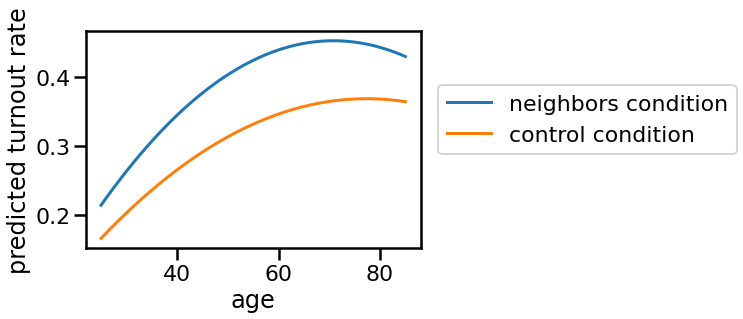

In [ ]:
plt.plot(ages, y_t_hat, label='neighbors condition')
plt.plot(ages, y_c_hat, label='control condition')
plt.xlabel('age')
plt.ylabel('predicted turnout rate')
plt.legend(bbox_to_anchor=(1.02, 0.8))

Text(0, 0.5, 'estimated CATE')

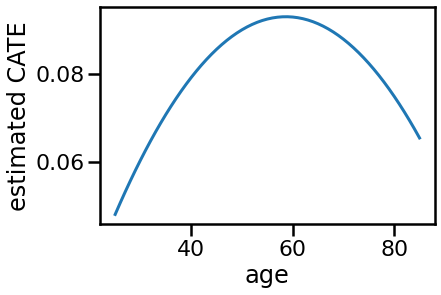

In [ ]:
plt.plot(ages, y_t_hat - y_c_hat)
plt.xlabel('age')
plt.ylabel('estimated CATE')

We find that according to this model, the estimated average treatment effect peaks around 60 years old, and the effect size is much smaller among young and old voters.


A note here: in all this analysis we have neglected the uncertainty estimation. It can be done relying on the uncertainty estimation of the regression coefficient, but would be much harder if we use other regression algorithms.

A seconde note: we have relied on a single model here (like in the S-learner). As an extension you could to the same analysis with 2 models, as in the T-learner, with some slight changes in the theory and code. It can avoid the need to include interaction terms, but not the quadratic extension of the age variable.